# Predicting Early Readmission for Diabetes Patients
## By: Wilson Andrés Pinillo

**Dataset Overview:**
The [dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008) captures ten years (1999-2008) of clinical care at 130 U.S. hospitals and integrated delivery networks. It includes records of patients diagnosed with diabetes, documenting various treatments, laboratory results, medications, and hospital stays of up to 14 days. The primary goal is to predict three types of patient outcomes: no readmission, readmission within 30 days, and readmission after 30 days of discharge.

### **Objective:**
Develop a classification model to categorize diabetic patient readmissions into three distinct groups based on their readmission timeline within 30 days of discharge.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


### Data preprocessing

In the data preprocessing phase, irrelevant columns are removed, missing values are handled using placeholders, and categorical variables are encoded into numerical format using LabelEncoder. LabelEncoder may introduce issues by assigning arbitrary values to categories without considering their relationships. One-hot encoding is avoided to prevent sparse datasets, as some columns, like diagnostics, have 950+ distinct values, which would increase dimensionality and reduce model efficiency.


In [4]:
def clean_and_encode_data(X: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the given DataFrame by dropping specified variables, handling missing values,
    and encoding categorical features.

    Parameters:
        X (pd.DataFrame): The DataFrame to clean and encode.

    Returns:
        pd.DataFrame: The cleaned and encoded DataFrame.
    """

    # Drop variables with high percentages of missing values
    X = X.drop(['weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult'], axis=1)

    # Drop variables where all records have the same value
    X = X.drop(['citoglipton', 'examide'], axis=1)

    # Fill NA values with a placeholder 'Unknown'
    X['race'] = X['race'].fillna('Unknown')
    X['diag_1'] = X['diag_1'].fillna('Unknown')
    X['diag_2'] = X['diag_2'].fillna('Unknown')
    X['diag_3'] = X['diag_3'].fillna('Unknown')

    # Replace invalid values in 'gender' with a placeholder
    X['gender'] = X['gender'].replace('Unknown/Invalid', 'Unknown')

    # Identify and encode categorical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    print(f'Identified categorical columns: {categorical_cols}')

    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

    feature_columns = X.columns.tolist()

    return X[feature_columns]


In [5]:
le = LabelEncoder()
y_encoded = le.fit_transform(y.values.ravel())
X_encoded = clean_and_encode_data(X)

Identified categorical columns: ['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


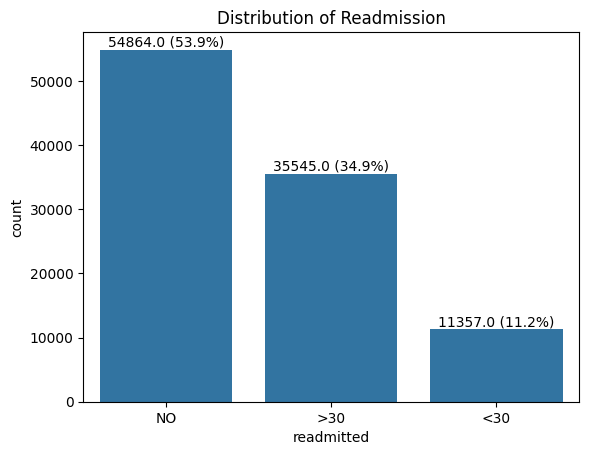

In [ ]:
# Distribution of Readmission (y)
ax = sns.countplot(x='readmitted', data=y)
ax.set_title('Distribution of Readmission')
total_count = y['readmitted'].count()
for p in ax.patches:
    count = p.get_height()
    percentage = (count / total_count) * 100
    ax.annotate(f'{count} ({percentage:.1f}%)',
                (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom', fontsize=10)

The **dataset is imbalanced**. The class "Readmission before 30 days" has only 11% of the data, which is significantly lower than the other classes.Classes with less than 20% representation are considered as minority classes and can negatively impact model performance. Models trained on imbalanced datasets can become biased towards the majority class,  resulting in poor performance on the minority class.


**Recommended Actions**

Class Weights:
Apply class weights in the model to give more importance to the minority class. This can help the model learn from the minority class more effectively.

Evaluation Metrics:
If we measure the effectiveness of our model by the number of correct predictions (Accuracy), considering only the majority class, we may have a false sense of the model's performance.
To assess that we'll focus on metrics that give better insights into model performance on imbalanced datasets, in this case the recall. Recall is important in contexts like medical diagnoses or fraud detection, where missing a positive case can have serious consequences.

### Feature Importance

Identify and retain the most relevant features that contribute to the model's predictive power.

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Fit the Random Forest model
model_fi = RandomForestClassifier(random_state=42)
model_fi.fit(X_encoded, y_encoded)

# Get feature importances
importance = model_fi.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Select important features
feature_importance_df['cumulative_importance'] = feature_importance_df['Importance'].cumsum()
important_features = feature_importance_df[feature_importance_df['cumulative_importance'] <= 0.95]['Feature'].tolist()
X_features = X_encoded[important_features]

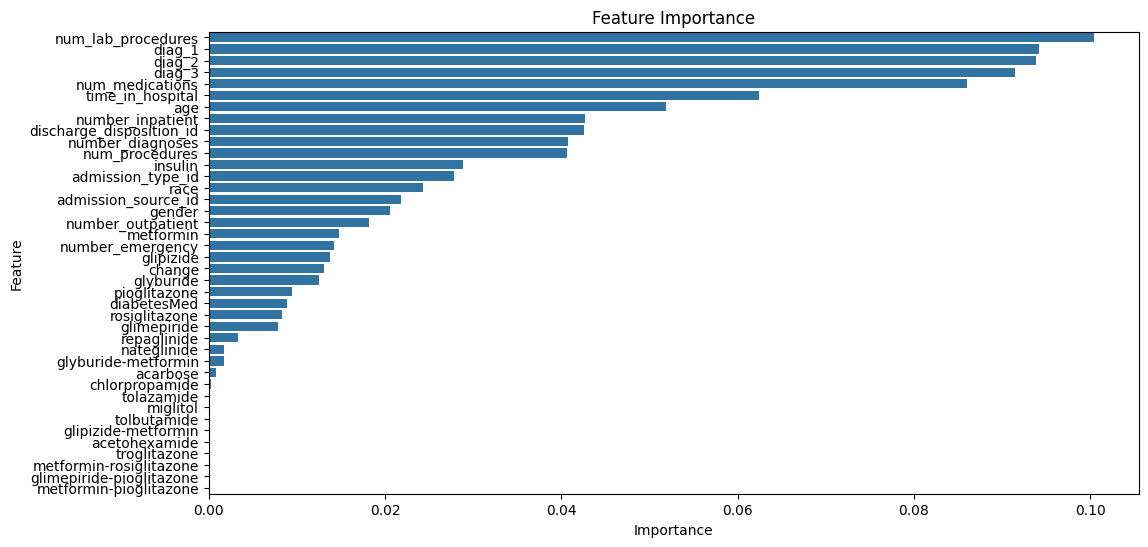

In [7]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

Next, Principal Component Analysis (PCA) is implemented to reduce dimensionality.

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [9]:
# Standardize the features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)
# Apply PCA
pca = PCA()
x_pca_ = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(data=x_pca_, columns=[f'PC{i+1}' for i in range(x_pca_.shape[1])])

### Train/test split

In [10]:
from sklearn.model_selection import train_test_split

# Train test split 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.20, random_state=42)

### Model Selection

In the model selection section, various algorithms are evaluated for predicting early readmission, starting with logistic regression as the baseline model. This is followed by a random forest, a Multi-layer Perceptron (MLP), and finally.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

#### Logistic Regression (Baseline model)

The baseline model is selected through grid search combined with cross-validation to ensure robust hyperparameter tuning. The model is set to account for class imbalances.

In [ ]:
def grid_search_cv_logit():

    grid_values = {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'newton-cg', 'sag']}
    lr = LogisticRegression(max_iter=1000, class_weight="balanced")
    lr_custom = GridSearchCV(lr, param_grid=grid_values, scoring='recall_weighted', cv=3)
    lr_custom.fit(X_train, y_train.ravel())

    print(f"Best Params: {lr_custom.best_params_}")
    print(f"Best Score (weighted recall): {lr_custom.best_score_}")

    return lr_custom

# GridSearchCV for LogisticRegression
logit_grid_search_results = grid_search_cv_logit()
logit = logit_grid_search_results.best_estimator_
logit_pred = logit.predict(X_test)

# Calculate metrics for LogisticRegression
accuracy_lr = logit.score(X_test, y_test)
recall_lr = recall_score(y_test.ravel(), logit_pred, average='weighted')
precision_lr = precision_score(y_test.ravel(), logit_pred, average='weighted')

print("Logit Results:", f"Accuracy: {accuracy_lr:.2f}, Recall: {recall_lr:.2f}, Precision: {precision_lr:.2f}")



Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Score (weighted recall): 0.49159824627113774
Logit Results: Accuracy: 0.49, Recall: 0.49, Precision: 0.51


#### Random Forest

The Random Forest model is optimized using grid search with cross-validation to fine-tune hyperparameters such as the number of trees, maximum depth, and splitting criteria. The model accounts for class imbalances by using weighted recall as the scoring metric, ensuring balanced performance across all classes.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def grid_search_cv_random_forest():

    rm = RandomForestClassifier()
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [10, 25],
        'min_samples_split': [2, 5],
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [1, 2]
    }

    random_forest = GridSearchCV(rm, param_grid, scoring='recall_weighted', cv=3)
    random_forest.fit(X_train, y_train.ravel())

    print(f"Best Params: {random_forest.best_params_}")
    print(f"Best Score (weighted recall): {random_forest.best_score_}")

    return random_forest

# GridSearchCV for RandomForest
random_forest_grid_search_results = grid_search_cv_random_forest()
random_forest = random_forest_grid_search_results.best_estimator_
rm_pred = random_forest.predict(X_test)

# Calculate metrics for RandomForest
accuracy_rm = random_forest.score(X_test, y_test)
recall_rm = recall_score(y_test.ravel(), rm_pred, average='weighted')
precision_rm = precision_score(y_test.ravel(), rm_pred, average='weighted')

print(f"Accuracy: {accuracy_rm:.2f}, Recall: {recall_rm:.2f}, Precision: {precision_rm:.2f}")



Best Params: {'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score (weighted recall): 0.5738957299485075
Accuracy: 0.57, Recall: 0.57, Precision: 0.55


#### Multi Layer Perceptron

The best MLP model is selected by testing various hyperparameters using different solvers (Adam and SGD) and adaptive learning rates. After scaling the data, multiple models are trained with different configurations. Their performance is evaluated based on training accuracy and loss, with results visualized through loss curves to identify the optimal parameters.

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import ConvergenceWarning

In [28]:
# Function to fit the model with the set of parameters to evaluate and plot the performance
def multi_layer_perceptron_clf(X, y, name):
    print("\nLearning on %s" % name)

    # Scale the features
    X = StandardScaler().fit_transform(X)
    mlps = []
    best_model = None
    best_score = 0

    # Set of parameters to analyze
    params = [
        {"solver": "adam", "learning_rate": "adaptive", "learning_rate_init": 0.01},
        {"solver": "adam", "learning_rate": "adaptive", "learning_rate_init": 0.03},
        {"solver": "sgd", "learning_rate": "adaptive", "learning_rate_init": 0.01, "momentum": 0.8},
        {"solver": "sgd", "learning_rate": "adaptive", "learning_rate_init": 0.03, "momentum": 0.8}
    ]

    labels = [
        "Adam - adaptive learning-rate 0.01",
        "Adam - adaptive learning-rate 0.03",
        "SGD - adaptive learning-rate 0.01, momentum 0.8",
        "SGD - adaptive learning-rate 0.03, momentum 0.8"
    ]

    for label, param in zip(labels, params):
        print("Training: %s" % label)

        mlp = MLPClassifier(
            hidden_layer_sizes=(64, 32),
            **param,
            max_iter=100,
            activation='relu',
            tol=0.0001,
            random_state=42
        )

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            mlp.fit(X, y)

        mlps.append(mlp)
        score = mlp.score(X, y)
        print("Training set score: %f" % score)
        print("Training set loss: %f" % mlp.loss_)

        # Save the model if it's the best score
        if score > best_score:
            best_score = score
            best_model = mlp

    # Save the best model to a file
    if best_model:
        joblib.dump(best_model, 'best_mlp_model.pkl')
        print(f"Best model saved with a score of {best_score:.4f}")

    # Plotting the loss curve
    for mlp, label in zip(mlps, labels):
        plt.plot(mlp.loss_curve_, label=label)

    plt.legend()
    plt.show()


Learning on Diabetes
Training: Adam - adaptive learning-rate 0.01
Training set score: 0.599408
Training set loss: 0.858029
Training: Adam - adaptive learning-rate 0.03
Training set score: 0.583956
Training set loss: 0.886538
Training: SGD - adaptive learning-rate 0.01, momentum 0.8
Training set score: 0.595760
Training set loss: 0.863111
Training: SGD - adaptive learning-rate 0.03, momentum 0.8
Training set score: 0.605328
Training set loss: 0.850674
Best model saved with a score of 0.6053


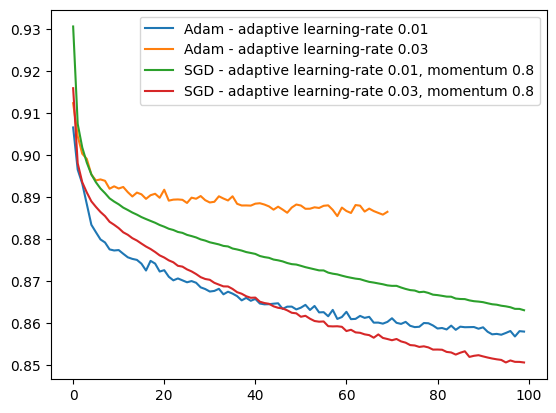

In [29]:
# Visualize performance and save the best MLP model
multi_layer_perceptron_clf(X_train, y_train, 'Diabetes')

In [35]:
# Load the model
best_mlp_model = joblib.load('best_mlp_model.pkl')

In [36]:
# Make predictions
mlp_pred = best_mlp_model.predict(X_test)
# Calculate metrics for MLP
accuracy_mlp = accuracy_score(y_test, mlp_pred)
precision_mlp = precision_score(y_test, mlp_pred, average='weighted')
recall_mlp = recall_score(y_test, mlp_pred, average='weighted')

print(f"Accuracy: {accuracy_mlp:.2f}, Precision: {precision_mlp:.2f}, Recall: {recall_mlp:.2f}")

Accuracy: 0.57, Precision: 0.53, Recall: 0.57


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


#### Neural Network

This approach builds a sequential neural network using Keras for multi-class classification, featuring an input layer with 128 neurons, two hidden layers with 64 and 32 neurons, and an output layer with 3 neurons utilizing softmax activation. Compiled with the Adam optimizer and categorical cross-entropy loss, the model optimizes for recall. Early stopping is employed to stop training if validation recall does not improve for 5 epochs, restoring the best weights for enhanced performance.

In [43]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [45]:
# One hot encoding target variable
y_train_encoded = to_categorical(y_train)

# Define sequiential model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['recall'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.9220 - recall: 0.4000 - val_loss: 0.9155 - val_recall: 0.3665
Epoch 2/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9076 - recall: 0.4333 - val_loss: 0.9002 - val_recall: 0.4815
Epoch 3/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9065 - recall: 0.4489 - val_loss: 0.9025 - val_recall: 0.4009
Epoch 4/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9055 - recall: 0.4414 - val_loss: 0.9007 - val_recall: 0.4839
Epoch 5/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.9020 - recall: 0.4227 - val_loss: 0.8972 - val_recall: 0.3989
Epoch 6/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9034 - recall: 0.4382 - val_loss: 0.8934 - val_recall: 0.4909
Epoch 7/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.8956 - recall: 0.4506 - val_loss: 0.8927 - val_recall: 0.4634
Epoch 8/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8928 - recall: 0.4363 - val_loss: 0.8915 - val_recall

In [47]:
# Make predictions
nn_pred = model.predict(X_test)
predicted_classes = np.argmax(nn_pred, axis=1)
# Calculate metrics for Neural Network
accuracy_nn = accuracy_score(y_test, predicted_classes)
precision_nn = precision_score(y_test, predicted_classes, average='weighted')
recall_nn = recall_score(y_test, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy_nn:.2f}, Precision: {precision_nn:.2f}, Recall: {recall_nn:.2f}")

637/637 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Accuracy: 0.58, Precision: 0.54, Recall: 0.58


## Model Evaluation

The performance of the selected classification models Logistic Regression, Decision Tree, Random Forest, and Neural Network was evaluated based on three key metrics: accuracy, precision, and recall. A bar chart was created to visually compare these metrics across the models.

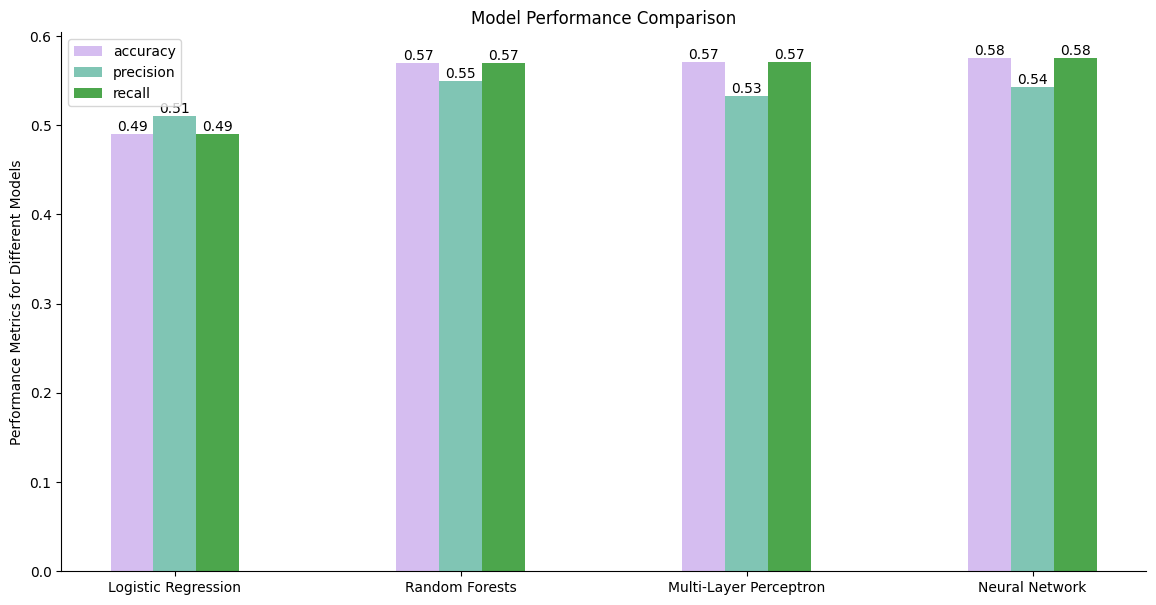

In [60]:
plt.figure(figsize=(14, 7))
ax = plt.subplot(111)

# Data for accuracy
models = ['Logistic Regression', 'Random Forests', 'Multi-Layer Perceptron', 'Neural Network']
values = [accuracy_lr, accuracy_rm, accuracy_mlp, accuracy_nn]
model = np.arange(len(models))

# Plotting accuracy bars
bars_accuracy = plt.bar(model, values, align='center', width=0.15, alpha=0.7, color='#c4a1ea', label='accuracy')
for bar in bars_accuracy:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Data for precision
values = [precision_lr, precision_rm, precision_mlp, precision_nn]
bars_precision = plt.bar(model + 0.15, values, align='center', width=0.15, alpha=0.7, color='#4aad95', label='precision')
for bar in bars_precision:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Data for recall
values = [recall_lr, recall_rm, recall_mlp, recall_nn]
bars_recall = plt.bar(model + 0.3, values, align='center', width=0.15, alpha=0.7, color='green', label='recall')
for bar in bars_recall:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.xticks(model + 0.15, models)
plt.ylabel('Performance Metrics for Different Models')
plt.title('Model Performance Comparison')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.show()


In the model performance comparison, the Logistic Regression model served as the baseline, achieving an accuracy of 0.49. Both the Random Forest and Multi-Layer Perceptron (MLP) models improved upon this baseline, each obtaining an accuracy of 0.57. The Neural Network emerged as the best-performing model with an accuracy of 0.58, demonstrating marginally better performance than the other models. The evaluation highlights the effectiveness of more complex models like the Neural Network in capturing patterns in the data, although the improvement is modest.

In [61]:
# Save the Neural Network model
joblib.dump(model, 'diabetes_classification_model.pkl')

['diabetes_classification_model.pkl']